## 投手を球種の割合でクラスタリングしてみる
２０２２年に投球のある投手のみ利用。  
pitcher_name, FF_rate, SI_rate....で適当に10個に分類。blrs/PAの上位を表示

In [87]:
import pathlib
import pandas as pd
import glob
import numpy as np
import math

In [164]:
pd.options.display.max_columns = 100
pd.options.display.max_rows = 100

### データ読み込み

In [5]:
data_path = pathlib.Path('/Users/shirai1/work/baseball_analysis/data_collection/data/baseball_savant')

In [47]:
# 2022年に投球がある全選手のデータを読み込み
player_df_dict = {}
for i, csv_file in enumerate(list(data_path.glob('*.csv'))):
    if i % 100 == 0:
        print(f"{i} / {len(list(data_path.glob('*.csv')))}")
    df = pd.read_csv(csv_file)
    if '2022' in df['game_date'].str[:4].unique().tolist():
        # 100球より投球数が少ない選手は弾く
        if len(df['game_date'].str.startswith('2022')) < 100:
            continue
        player_df_dict[csv_file.stem] = df[df['game_date'].str.startswith('2022')]

print(f"2022年に投球数が100以上のピッチャーは{len(player_df_dict)}人")

0 / 870
100 / 870
200 / 870
300 / 870
400 / 870
500 / 870
600 / 870
700 / 870
800 / 870
2022年に投球数が100以上のピッチャーは356人


### ピッチャーごとにローデータ作成
球種ごとの割合を出す  
球種は、['SL', 'SI', 'CH', 'CU', 'FF', 'FS', 'FC', 'KC', nan, 'FA', 'CS',　'EP']  
SL/スライダー, SI/シンカー, CH/チェンジアップ, CU/カーブ, FF/4シーム, FS/スプリットフィンガー, FC/カッター, KC/ナックルカーブ, FA/4シーム？？, CS/スローカーブ, EP/イーファスピッチ(超スローボール)

In [323]:
pt_dict = {
    'SL': 'スライダー', 
    'SI': 'シンカー', 
    'CH': 'チェンジアップ', 
    'CU': 'カーブ', 
    'FF': '4シーム', 
    'FS': 'スプリットフィンガー',
    'FC': 'カッター', 
    'KC': 'ナックルカーブ', 
    'FA': '不明(4シームと同じ？？)', 
    'CS': 'スローカーブ', 
    'EP': 'イーファス'
}

In [57]:
all_df = pd.concat([player_df_dict[val] for val in player_df_dict.keys()])

In [59]:
all_df.groupby('pitch_type').size()

pitch_type
CH     35870
CS        54
CU     28679
EP        42
FA       103
FC     25373
FF    101516
FS      4829
KC      5240
SI     47590
SL     64969
dtype: int64

In [119]:
all_pitch_types = [val for val in all_df.pitch_type.unique().tolist() if isinstance(val, str)]

In [130]:
results = []
for player in player_df_dict.keys():
    tmp_df = player_df_dict[player]
    tmp_df = tmp_df[~tmp_df['pitch_type'].isnull()]  # pitch_typeがnullを削除
    picth_types = tmp_df.groupby('pitch_type').size().index
    cnts  = tmp_df.groupby('pitch_type').size().values
    pitch_cnt_dict = dict(zip(picth_types, cnts))
    total_cnt = cnts.sum()
    
    result = [player]
    for pitch_type in all_pitch_types:
        if pitch_type in pitch_cnt_dict.keys():
            result.append(round(pitch_cnt_dict[pitch_type] / total_cnt, 5))
        else:
            result.append(0.0)
    results.append(result.copy())

### k-meansでクラスタリング

In [200]:
from sklearn.cluster import KMeans
from sklearn import preprocessing
import matplotlib.pyplot as plt

In [188]:
#　正規化
mm = preprocessing.MinMaxScaler()
data = np.array(results)[:, 1:]  # 選手名以外を利用。
min_max_data = mm.fit_transform(data)

In [266]:
num_clusters = 5

model = KMeans(
    n_clusters=num_clusters,
    init='k-means++',     # k-means++法によりクラスタ中心を選択
    n_init=10,
    max_iter=300,
    random_state=0
).fit(min_max_data)

In [267]:
result_df = pd.DataFrame(results, columns=['player_name'] + all_pitch_types)

In [268]:
result_df['cluster'] = model.labels_

### エルボー法でのクラスタ数の妥当性確認(グラフからサチるクラスタ数を把握する。)

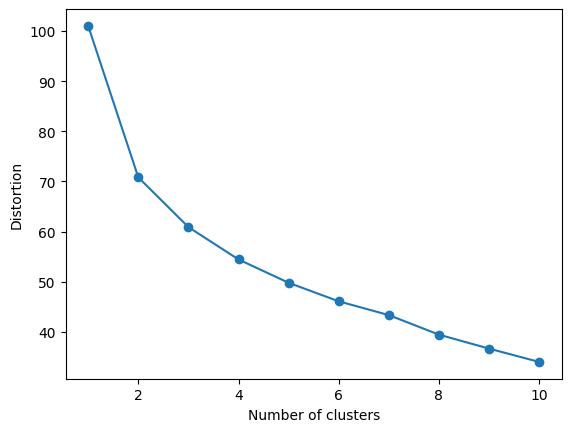

In [221]:
distortions = []

for i  in range(1,11):                # 1~10クラスタまで一気に計算 
    km = KMeans(n_clusters=i,
                init='k-means++',     # k-means++法によりクラスタ中心を選択
                n_init=10,
                max_iter=300,
                random_state=0)
    km.fit(min_max_data)                         # クラスタリングの計算を実行
    distortions.append(km.inertia_)   # km.fitするとkm.inertia_が得られる

plt.plot(range(1,11),distortions,marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

### PCAでの次元削減と2次元プロット

In [222]:
from sklearn.decomposition import PCA

In [223]:
pca = PCA(n_components=2)
pca.fit(min_max_data)

PCA(n_components=2)

In [224]:
x_pca = pca.transform(min_max_data)
pca_df = pd.DataFrame(x_pca)
pca_df['cluster'] = result_df['cluster'].values

,0,1,cluster
0,0.612085,-0.238100,0
1,-0.408052,0.228192,2
2,-0.046142,-0.233884,1
3,0.560359,-0.276286,0
4,0.737989,-0.084053,0
...,...,...,...
351,0.274385,0.331515,3
352,-0.289951,-0.287571,1
353,-0.403601,-0.019901,2
354,-0.377568,0.062128,2


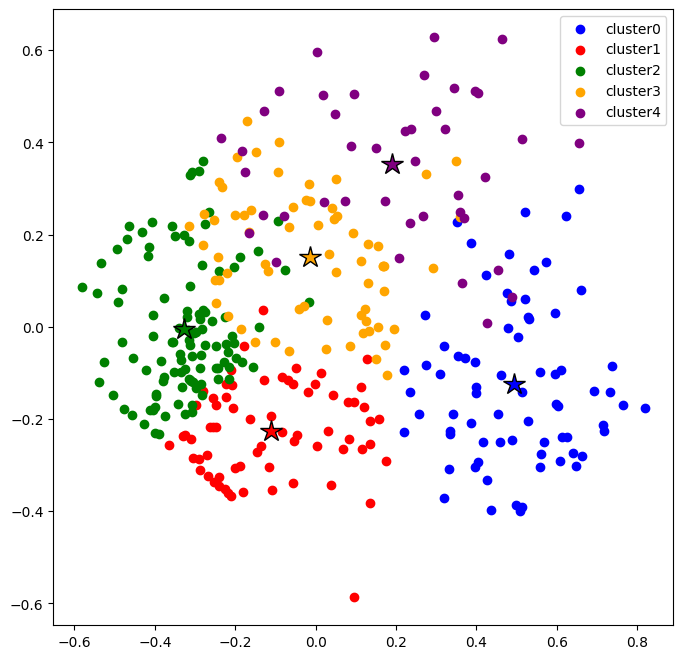

In [269]:
# 可視化
fig = plt.figure(figsize = (8, 8))
colors = ['blue', 'red', 'green', 'orange', 'purple']

for i in range(num_clusters):
    tmp = pca_df.loc[pca_df['cluster'] == i]
    mean_x = tmp[0].mean()
    mean_y = tmp[1].mean()
    plt.plot(mean_x, mean_y, marker='*', color=colors[i], markeredgecolor='black', markersize=16)
    plt.scatter(tmp[0], tmp[1], label=f'cluster{i}', color=colors[i])

# 各要素にDataFrameのインデックスの数字をラベルとして付ける

plt.legend()

In [277]:
# PCAの結果の数値を元のDFに付与
result_df['pca_0'] = pca_df[0]
result_df['pca_1'] = pca_df[1]

In [250]:
print(mean_x, mean_y)

0.19051550692476824 0.35345084615530864


In [279]:
def calc_2point_distance(x, mean_x, mean_y):
    a = np.array([x['pca_0'], x['pca_1']])
    b = np.array([mean_x, mean_y])
    distance=np.linalg.norm(b-a)
    return distance

In [280]:
# クラスタの中心からの距離を付与
tmp_dfs = []
for i in range(num_clusters):
    tmp_df = result_df[result_df['cluster'] == i]
    # tmp_df['distance_from_center'] = tmp_df.apply(calc_2point_distance, axis=1)
    tmp_df['distance_from_center'] = tmp_df.apply(calc_2point_distance, args=(mean_x, mean_y), axis=1)
    tmp_dfs.append(tmp_df)
    
distance_df = pd.concat(tmp_dfs).reset_index(drop=True)

/Users/shirai1/.local/share/virtualenvs/baseball_analysis-BxQ8eODn/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/Users/shirai1/.local/share/virtualenvs/baseball_analysis-BxQ8eODn/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/Users/shirai1/.local/share/virtualenvs/baseball_analysis-BxQ8eODn/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set

In [333]:
# クラスタごとの傾向の把握
topn_pt = 3

for i in range(num_clusters):
    print(f"cluster:{i}")
    tmp_df = result_df[result_df['cluster'] == i]
    top3_pt_names = tmp_df[all_pitch_types].mean().sort_values(ascending=False)[:topn_pt].index.tolist()
    top3_pt_scores = tmp_df[all_pitch_types].mean().sort_values(ascending=False)[:topn_pt].values.tolist()
    for i in range(topn_pt):
        print(f'投球数TOP{i + 1}: {pt_dict[top3_pt_names[i]]} [割合: {top3_pt_scores[i]}]')

cluster:0
投球数TOP1: シンカー [割合: 0.47783597222222224]
投球数TOP2: スライダー [割合: 0.27175583333333336]
投球数TOP3: チェンジアップ [割合: 0.10690374999999998]
cluster:1
投球数TOP1: スライダー [割合: 0.4293349999999999]
投球数TOP2: 4シーム [割合: 0.3767710294117648]
投球数TOP3: シンカー [割合: 0.08424499999999997]
cluster:2
投球数TOP1: 4シーム [割合: 0.5480004672897195]
投球数TOP2: スライダー [割合: 0.19007252336448602]
投球数TOP3: チェンジアップ [割合: 0.09419672897196264]
cluster:3
投球数TOP1: 4シーム [割合: 0.2941583582089553]
投球数TOP2: チェンジアップ [割合: 0.23735417910447756]
投球数TOP3: カーブ [割合: 0.15228895522388058]
cluster:4
投球数TOP1: カッター [割合: 0.3645833333333333]
投球数TOP2: 4シーム [割合: 0.18124261904761904]
投球数TOP3: シンカー [割合: 0.1714092857142857]


In [335]:
distance_df[distance_df['player_name'] == 'Darvish_Yu']

,player_name,SL,SI,CH,CU,FF,FS,FC,KC,FA,CS,EP,cluster,pca_0,pca_1,distance_from_center
323,Darvish_Yu,0.18392,0.09419,0.0,0.04393,0.24162,0.07967,0.35108,0.00558,0.0,0.0,0.0,4,0.072891,0.27258,0.142744


In [336]:
distance_df[distance_df['player_name'] == 'Ohtani_Shohei']

,player_name,SL,SI,CH,CU,FF,FS,FC,KC,FA,CS,EP,cluster,pca_0,pca_1,distance_from_center
113,Ohtani_Shohei,0.39064,0.0369,0.0,0.08634,0.27577,0.11982,0.09053,0.0,0.0,0.0,0.0,1,-0.048728,-0.090439,0.504258


In [337]:
distance_df[distance_df['player_name'] == 'Verlander_Justin']

,player_name,SL,SI,CH,CU,FF,FS,FC,KC,FA,CS,EP,cluster,pca_0,pca_1,distance_from_center
150,Verlander_Justin,0.28347,0.0,0.02417,0.18796,0.50441,0.0,0.0,0.0,0.0,0.0,0.0,2,-0.307048,-0.063532,0.649187
